# Fitting a weight function to the Lamb-Oseen vortex

We assume that the Biot-Savart law can be written with a weight function like
$$
\vec u_w (\vec r) = \frac{\Gamma}{4 \pi} \oint_C \frac{\hat t \times \vec \xi(\ell)}{\|\vec \xi (\ell)\|^2} w\left(\tfrac{\Delta}{a}\right) d\ell
$$
where $a$ is the vortex core radius, $\vec \xi (\ell) = \vec r - \vec C(\ell)$ is the vector from $\vec C(\ell)$ to $\vec r$, $\Delta$ is some measure (chosen by us) of the distance between $\vec r$ and $\vec C(\ell)$, and $w$ is a weight function which is assumed to be zero when $\Delta = 0$ and one when $\Delta = \alpha a$ with $\alpha$ being an integer constant selected based on the problem.

**We want to fit our weight function such that when given a Lamb-Oseen vortex, we can recover the correct velocity field.** That is, $w\, | \, \vec u_w \approx \vec u_{LO}$

The velocity field of Lamb-Oseen vortex in cylindrical coordinates is given by
$$
\vec u_{LO}(s, \phi, z) = \frac{\Gamma}{2 \pi s} \left(1 - e^{-s^2 / a^2}\right) \hat \phi
$$

We can assume $\Gamma = 1$ without loss of generality.

## Simplifying the Problem

Let the Lamb-Oseen vortex be aligned with the $x$-axis. The vortex is infinitely long, so $\vec u_{LO}$ is the same for any $z$, therefore we can set $z=0$ without loss of generality. The vortex also has axial symmetry, so we can set $\phi=0$, i.e., we evaluate the velocity only along the $y$-axis. Then the velocity will always be in the $\hat z$ direction, so we only evaluate the $z$-component of the velocity.

We will assume that $\Delta$ depends on the radial distance $\vec \xi$ like
$$
\Delta \equiv \| \vec \xi \|^2
$$
and that $a = 1$.

With the above we get
$$
\begin{align}
\vec r &= y \hat y \\
\hat t &= \hat x \\
\vec C(\ell) &= \ell \hat x \\
\vec \xi(\ell) &= y \hat y - \ell \hat x \\
\|\vec \xi(\ell)\|^2 &= y^2 + \ell^2 \\
\vec r \times \vec \xi(\ell) &= y \ell \hat z
\end{align}
$$
so we can rewrite the Bio-Savart law as
$$
u_w(y) = \frac{1}{4 \pi} \int_{-\infty}^\infty \frac{y \ell}{y^2 + \ell^2} w\left(y^2 + \ell^2\right) d\ell
$$
and the velocity of the Lamb-Oseen vortex as
$$
u_{LO}(y) = \frac{1}{2 \pi y} \left(1 - e^{-y^2}\right)
$$



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
def u_LO(y):
    return (1 - np.exp(-y**2)) / (2 * np.pi * y)

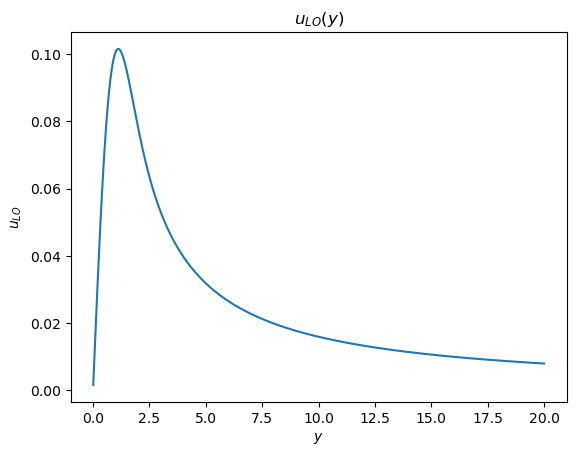

In [9]:
y_vec = np.linspace(0.01, 20, 1000)
u_LO_vec = u_LO(y_vec)
plt.plot(y_vec, u_LO_vec)
plt.title('$u_{LO}(y)$')
plt.xlabel('$y$')
plt.ylabel('$u_{LO}$')
plt.show()

## Weight Function

We will model the weight function as Bernstein polynomial, however, any other polynomial basis could be used.

A Bernstein polynomial of degree $n$ is given by
$$
B_n (x) = \sum_{k=0}^n \beta_k b_{k, n}(x)
$$
where \beta_k are the Bernstein coefficients (i.e., the coefficients we need to fit) and $b_{k, n}(x)$ are the Bernstein basis polynomials given by
$$
b_{k, n}(x) = \binom{n}{k} x^k (1 - x)^{n-k},\quad k = 0, 1, \ldots, n
$$
where $\binom{n}{k} = n!/k!(n-k)!$ is the binomial coefficient. Note, for a Bernstein polynomial of degree $n$, there are $n+1$ Bernstein basis polynomials.

**De Casteljau's algorithmt** is a numerically stable, recursive, algorithm for computing the Bernstein basis polynomials.

A Bernstein polynomial of degree $n$ can be evaluated at $x_0$ with the following
$$
\begin{align}
\alpha_i^{(0)} &= \beta_i && r=0; && i=0, \dots, n\\
\alpha_i^{(r)} &= \alpha_i^{(r-1)}(1-x_0) + \alpha_{i+1}^{(r-1)} x_0 && r=0,\dots,n; && i=0,\dots,n-r
\end{align}
$$
where $i$ indexes the control points and $r$ level of recurrence. $\beta_i$ is the $i$-th Bernstein coefficient.

The result $B(x_0)$ is given by
$$
B_n(x_0) = \alpha_0^{(n)}
$$
that is, the $n$-th recurrence of the $0$-th control point.

**The Implementation of De Casteljau's algorithm** will compute the recurrence levels in descending order and the control points in ascending order. That is, we start with $r = n$ and $i = 0$ and end with $r = 0$ and $i = n$.

In [155]:
class BernsteinPolynomial:
    def __init__(self, beta):
        self.set_beta(beta)
        
    # def __repr__(self):
    #     return f'BernsteinPolynomial({self.beta})'
    
    def set_beta(self, beta):
        self.beta = beta
        self.n = len(beta) - 1
    
    def __call__(self, x0, beta=None):
        # print('(DEBUG) self.beta =', self.beta)
        # print('(DEBUG) self.n =', self.n)
        # print('(DEBUG) x0 =', x0)
        
        if beta is not None:
            self.set_beta(beta)
        
        alpha = np.zeros((self.n + 1, self.n + 1))
        # -1 because range does not include the last value
        for i in range(self.n, -1, -1):
            # print('(DEBUG) i =', i)
            # + 1 because range does not include the last value
            for r in range(0, self.n - i + 1):
                # print('(DEBUG) r =', r)
                if r == 0:
                    # print(f'(DEBUG) r==0, alpha[{r}, {i}] =' , self.beta[i])
                    alpha[r, i] = self.beta[i]
                else:
                    alpha[r, i] = alpha[r - 1, i] * (1 - x0) + alpha[r-1, i + 1] * x0
        
        # print('(DEBUG) alpha =\n', alpha)
        return alpha[self.n, 0]           

In [156]:
bp = BernsteinPolynomial(np.ones(4))
bp(0.5)

1.0

## Validating our Bernstein Polynomial Implementation

A Bernstein polynomial of degree $n$ is given by
$$
B_n (x) = \sum_{k=0}^n \beta_k b_{k, n}(x)
$$
Then the first $n=0, 1, 2, 3$ Bernstein polynomials are
$$
\begin{align}
B_0(x) &= \beta_0 \\
B_1(x) &= \beta_0 (1 - x) + \beta_1 x \\
B_2(x) &= \beta_0 (1 - x)^2 + \beta_1 \cdot 2x(1-x) + \beta_2 x^2 \\
B_3(x) &= \beta_0 (1 - x)^3 + \beta_1 \cdot 3x (1 - x)^2 + \beta_2 \cdot 3 x^2 (1 - x) + \beta_3 x^3 \\
B_4(x) &= \beta_0 (1 - x)^4 + \beta_1 \cdot 4x (1 - x)^3 + \beta_2 \cdot 6 x^2 (1 - x)^2 + \beta_3 \cdot 4 x^3 (1 - x) + \beta_4 x^4
\end{align}
$$


In [157]:
def BP2(x, beta):
    return beta[0] * (1 - x)**2 + beta[1] * 2 * x * (1 - x) + beta[2] * x**2

def BP4(x, beta):
    return beta[0] * (1 - x)**4 + beta[1] * 4 * x * (1 - x)**3 + beta[2] * 6 * x**2 * (1 - x)**2 + beta[3] * 4 * x**3 * (1 - x) + beta[4] * x**4

In [158]:
beta = np.arange(5)
x0 = 0.12
print(BP4(x0, beta))

0.48000000000000004


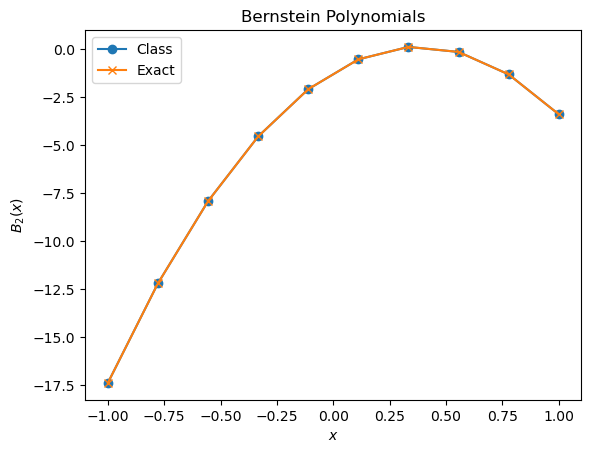

In [159]:
x_vec = np.linspace(-1, 1, 10)
beta = [-1.2, 2.3, -3.4]
bp = BernsteinPolynomial(beta)
y_vec = np.array([bp(x) for x in x_vec])
y_vec_exact = BP2(x_vec, beta)
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_2(x)$')
plt.show()

beta = [ 0.34192916  9.38342797  2.519155   -3.38957159 -6.86422747]
Error = 7.114996587511155e-14


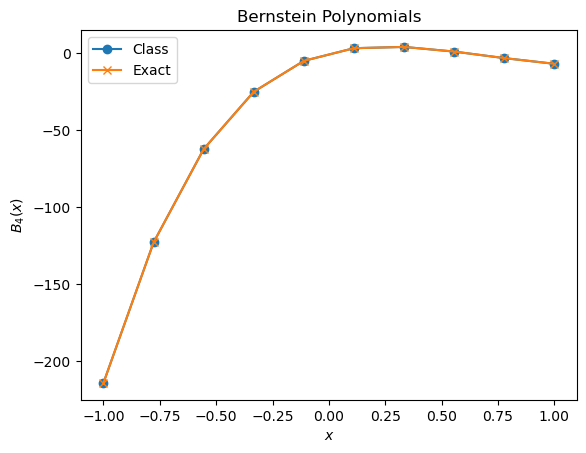

In [164]:
x_vec = np.linspace(-1, 1, 10)
beta = np.random.default_rng().uniform(-10, 10, 5)
print('beta =', beta)
bp = BernsteinPolynomial(beta)
y_vec = np.array([bp(x) for x in x_vec])
y_vec_exact = BP4(x_vec, beta)
print('Error =', np.linalg.norm(y_vec - y_vec_exact))
plt.plot(x_vec, y_vec, 'o-', label='Class')
plt.plot(x_vec, y_vec_exact, 'x-', label='Exact')
plt.legend()
plt.title('Bernstein Polynomials')
plt.xlabel('$x$')
plt.ylabel('$B_4(x)$')
plt.show()

## Fitting the Weight Function

We will use `scipy.optimize.curve_fit` to fit the weight function.

Using the variable names from the documentation (see [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)):
- `f` is the function we want to fit, i.e., the weighted Biot-Savart law
- `xdata` is an array of the independent variables where the data is measured, i.e., values of $y$ given to the weighted Biot_Savart law
- `ydata` is an array of the data we want to fit our function to, i.e., the velocity of the Lamb-Oseen vortex in the $\hat z$ direction.
- `p0` is an initial guess for the parameters of the function we want to fit. We should not need to provide this because the number of parameters is determined when the weight function is initialized.

In [3]:
def u_w(y, w):
    return sp.integrate.quad(lambda l: y * l * w(y**2 + l**2) / (y**2 + l**2), -np.inf, np.inf)[0] / (4 * np.pi)

In [ ]:
def w():